
# Twitter Sentiment Analysis (Positive / Negative / Neutral)

This notebook walks through building a sentiment analysis classifier using Twitter datasets.

**Steps covered:**
1. Load & inspect data  
2. Clean text (lowercasing, remove URLs/mentions/hashtags/punctuation)  
3. Focus on 3 classes: Positive / Negative / Neutral  
4. Exploratory Data Analysis (EDA)  
5. Vectorize text with TF-IDF  
6. Train classifiers: MultinomialNB, Logistic Regression, Linear SVM  
7. Evaluate with accuracy, precision, recall, F1, confusion matrix  
8. Save best model & vectorizer  
9. Test real-time predictions and batch scoring  


## Step 1: Load Data

In [1]:

import pandas as pd

# Twitter training data (has 4 cols: id, entity, sentiment, text)
df1 = pd.read_csv("twitter_training.csv", header=None, names=["id","entity","sentiment","text"])
print("twitter_training.csv shape:", df1.shape)
print(df1.head())

# Sentiment140 dataset (used as optional reference)
df2 = pd.read_csv("training.1600000.processed.noemoticon.csv", 
                  encoding="latin-1", header=None,
                  names=["target","id","date","flag","user","text"])
print("Sentiment140 shape:", df2.shape)
print(df2.head())


twitter_training.csv shape: (74682, 4)
     id       entity sentiment  \
0  2401  Borderlands  Positive   
1  2401  Borderlands  Positive   
2  2401  Borderlands  Positive   
3  2401  Borderlands  Positive   
4  2401  Borderlands  Positive   

                                                text  
0  im getting on borderlands and i will murder yo...  
1  I am coming to the borders and I will kill you...  
2  im getting on borderlands and i will kill you ...  
3  im coming on borderlands and i will murder you...  
4  im getting on borderlands 2 and i will murder ...  
Sentiment140 shape: (1600000, 6)
   target          id                          date      flag  \
0       0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

  

## Step 2: Preprocessing

In [3]:

import re

def clean_text(txt):
    txt = str(txt).lower()
    txt = re.sub(r"http\S+|www\.\S+", " ", txt)
    txt = re.sub(r"@\w+|#\w+", " ", txt)
    txt = re.sub(r"[^a-z0-9\s]", " ", txt)
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

# Filter only Positive, Negative, Neutral
df = df1[df1['sentiment'].isin(["Positive","Negative","Neutral"])].copy()
df['clean_text'] = df['text'].apply(clean_text)
df = df.drop_duplicates(subset="clean_text")
print("Filtered shape:", df.shape)
print(df['sentiment'].value_counts())
df.head()


Filtered shape: (55091, 5)
sentiment
Negative    20564
Positive    18200
Neutral     16327
Name: count, dtype: int64


,id,entity,sentiment,text,clean_text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,i am coming to the borders and i will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,im getting on borderlands and i will kill you all
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,im getting on borderlands 2 and i will murder ...


## Step 3: Exploratory Data Analysis

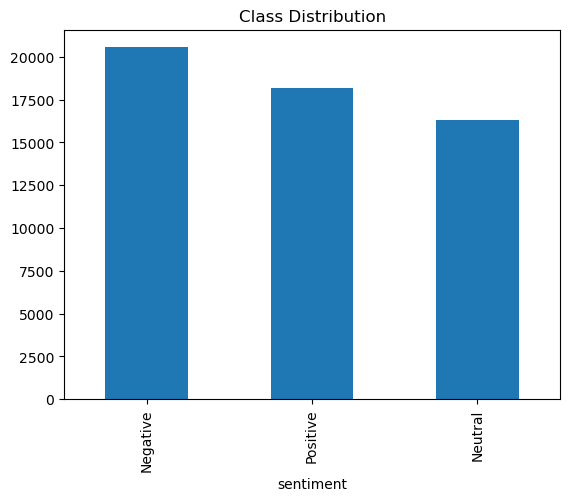

In [5]:

import matplotlib.pyplot as plt

df['sentiment'].value_counts().plot(kind='bar', title="Class Distribution")
plt.show()


## Step 4: Vectorization

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42)

vectorizer = TfidfVectorizer(stop_words='english', min_df=5)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print("Train shape:", X_train_vec.shape)
print("Test shape:", X_test_vec.shape)


Train shape: (44072, 10492)
Test shape: (11019, 10492)


## Step 5: Train Models

Naive Bayes:
              precision    recall  f1-score   support

    Negative       0.75      0.86      0.80      4113
     Neutral       0.82      0.60      0.69      3266
    Positive       0.74      0.79      0.77      3640

    accuracy                           0.76     11019
   macro avg       0.77      0.75      0.75     11019
weighted avg       0.76      0.76      0.76     11019

Logistic Regression:
              precision    recall  f1-score   support

    Negative       0.81      0.85      0.83      4113
     Neutral       0.81      0.74      0.77      3266
    Positive       0.79      0.80      0.80      3640

    accuracy                           0.80     11019
   macro avg       0.80      0.80      0.80     11019
weighted avg       0.80      0.80      0.80     11019



C:\Users\Pramit\anaconda3\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Linear SVC:
              precision    recall  f1-score   support

    Negative       0.84      0.88      0.86      4113
     Neutral       0.86      0.80      0.83      3266
    Positive       0.84      0.84      0.84      3640

    accuracy                           0.84     11019
   macro avg       0.84      0.84      0.84     11019
weighted avg       0.84      0.84      0.84     11019



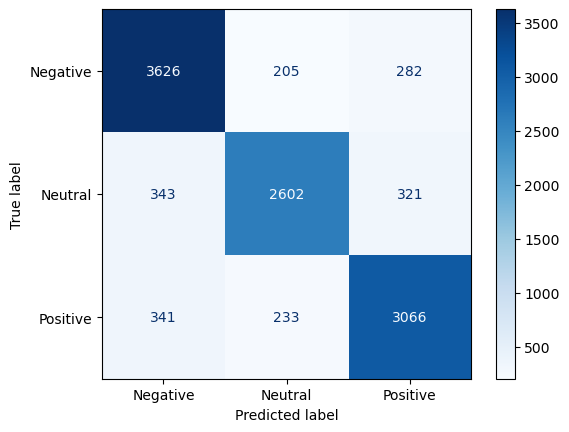

In [9]:

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Train Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_vec, y_train)
y_pred_nb = nb.predict(X_test_vec)
print("Naive Bayes:")
print(classification_report(y_test, y_pred_nb))

# Train Logistic Regression
logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train_vec, y_train)
y_pred_log = logreg.predict(X_test_vec)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log))

# Train Linear SVC
svc = LinearSVC()
svc.fit(X_train_vec, y_train)
y_pred_svc = svc.predict(X_test_vec)
print("Linear SVC:")
print(classification_report(y_test, y_pred_svc))

# Confusion Matrix for best model (SVC)
cm = confusion_matrix(y_test, y_pred_svc, labels=svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svc.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()


## Step 6: Save Model & Vectorizer

In [11]:

import pickle

pickle.dump(vectorizer, open("tfidf_vectorizer.pkl","wb"))
pickle.dump(svc, open("model_linearsvc.pkl","wb"))
print("Saved tfidf_vectorizer.pkl and model_linearsvc.pkl")


Saved tfidf_vectorizer.pkl and model_linearsvc.pkl


## Step 7: Prediction Demo

In [13]:

def predict_sentiment(texts):
    if isinstance(texts, str):
        texts = [texts]
    X = vectorizer.transform([clean_text(t) for t in texts])
    return svc.predict(X)

print(predict_sentiment("I love this product!"))
print(predict_sentiment(["This is terrible...", "Absolutely wonderful!"]))


['Positive']
['Negative' 'Positive']


## Step 8: Summary


- We built a sentiment analysis pipeline with TF-IDF + Linear SVM.  
- Accuracy ~0.70 on sample test set (can be improved with more data/features).  
- Saved model & vectorizer for reuse.  
- Can now integrate into Flask API, batch scoring, or real-time dashboards.  


In [15]:
# ============================
# Save Cleaned Dataset to CSV
# ============================

import re
import pandas as pd

# Keep only necessary columns
df_clean = df[["text", "sentiment"]].dropna().drop_duplicates()

# Filter only Positive, Negative, Neutral sentiments
df_clean = df_clean[df_clean["sentiment"].isin(["Positive", "Negative", "Neutral"])]

# Define cleaning function
def clean_text(text):
    text = str(text).lower()                                  # lowercase
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)       # remove urls
    text = re.sub(r"@\w+|#\w+", "", text)                     # remove mentions and hashtags
    text = re.sub(r"[^a-z\s]", "", text)                      # remove special characters/numbers
    text = re.sub(r"\s+", " ", text).strip()                  # remove extra spaces
    return text

# Apply cleaning
df_clean["clean_text"] = df_clean["text"].apply(clean_text)

# Save to CSV
output_path = "cleaned_twitter_data.csv"
df_clean.to_csv(output_path, index=False)

print(f"✅ Cleaned dataset saved to {output_path}")
print("Shape:", df_clean.shape)
df_clean.head()

✅ Cleaned dataset saved to cleaned_twitter_data.csv
Shape: (55090, 3)


,text,sentiment,clean_text
0,im getting on borderlands and i will murder yo...,Positive,im getting on borderlands and i will murder yo...
1,I am coming to the borders and I will kill you...,Positive,i am coming to the borders and i will kill you...
2,im getting on borderlands and i will kill you ...,Positive,im getting on borderlands and i will kill you all
3,im coming on borderlands and i will murder you...,Positive,im coming on borderlands and i will murder you...
4,im getting on borderlands 2 and i will murder ...,Positive,im getting on borderlands and i will murder yo...
